In [7]:
import os
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchaudio
from Dataset import *
from Visual import *
from IPython.display import Audio, display
from Spectrogram import LogSpectrogramExtractor, MinMaxNormaliser


In [2]:
ANNOTATIONS_FILE = "/home/vitalex93/Desktop/Data_Science/Deep_Learning/DLproject/Data/features_30_sec.csv"
AUDIO_DIR = "/home/vitalex93/Desktop/Data_Science/Deep_Learning/DLproject/Data/genres_original/"
SAMPLE_RATE = 22050
NUM_SAMPLES = 22050

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=64
)

spectrogram = torchaudio.transforms.Spectrogram(
        
        n_fft=1024,
        hop_length=512,
        )

md = MusicSoundDataset(ANNOTATIONS_FILE, AUDIO_DIR, spectrogram,
                        SAMPLE_RATE, NUM_SAMPLES)
print(f"There are {len(md)} samples in the dataset.")
signal, label = md[10]




There are 1000 samples in the dataset.


In [3]:
dir = r"/home/vitalex93/Desktop/Data_Science/Deep_Learning/DLproject/Data/genres_original/blues/blues.00000.wav"

si, sa = torchaudio.load(dir)
si.shape

g = torch.randn(1, 661794)
si = si + (0.1**0.5)*torch.randn(1, 661794)
si

list(si.shape)
#torch.mean(si)



[1, 661794]

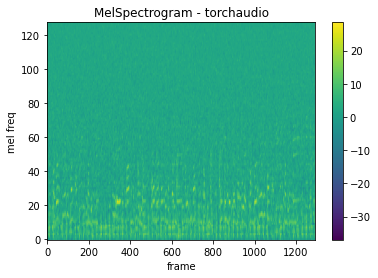

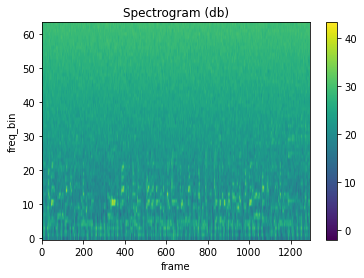

In [4]:
plot_mel(si, sa)
melspec = mel_spectrogram(si)
plot_spectrogram(melspec[0])


In [8]:
FRAME_SIZE = 512
HOP_LENGTH = 256

log_spectrogram_extractor = LogSpectrogramExtractor(FRAME_SIZE, HOP_LENGTH, si)
min_max_normaliser = MinMaxNormaliser(0, 1)